# Trying the Logic of Fillipo Model

In [1]:
import numpy as np
import os
import pandas as pd

placenta_data_raw = pd.read_csv("../smiles-transformer-master/data/Placenta_barrier.csv")
# Obtained from Padel_all_descriptors.ipynb based on Fillipo et al
# copied dict from Padel_all_descriptors.ipynb and saved for future purpose as csv
#target_labels = pd.DataFrame.from_dict(cross_placenta, orient='index')
#target_labels.to_csv(os.path.join(os.getcwd(), "Nix_TAM_inference", "fillipo_target_labels.csv"))

cross_placenta = pd.read_csv(os.path.join(os.getcwd(), "Nix_TAM_inference", "fillipo_target_labels.csv"), 
                             index_col=0).to_dict()["0"]

placenta_data_raw['prediction'] = placenta_data_raw['cid'].map(cross_placenta)
placenta_data_raw.head()

# these cids were skipped in Fillipo's paper
skipped_placenta_smiles = [2, 111, 166, 196, 229, 239, 240]
cid_skipped = []
for idx in skipped_placenta_smiles:
    cid_skipped.append(placenta_data_raw.iloc[idx]['cid'])
print(f'cid of skipped smiles:{cid_skipped}')

# finally we have 237 drugs
sorted_cid = list(placenta_data_raw['cid'])
sorted_target = []
for i in range(len(sorted_cid)):
    if i not in skipped_placenta_smiles:
        #print(sorted_cid[i])
        sorted_target.append(cross_placenta[sorted_cid[i]])
print(np.asarray(sorted_target), len(sorted_target))

placenta_target_labels = [1 if elem=='Yes' else 0 for elem in sorted_target]
print(placenta_target_labels, sum(placenta_target_labels))

filtered_data = placenta_data_raw[~placenta_data_raw["cid"].isin(cid_skipped)]
print(filtered_data.shape)

cid of skipped smiles:[948, 14969, 114976, 644073, 16130199, 90659973, 118984375]
['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'No' 'Yes'
 'Yes' 'Yes' 'Yes' 'No' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'No' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'No'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No'
 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'No' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes'

In [37]:
import os
import warnings        
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import MACCSkeys, RDKFingerprint, rdFingerprintGenerator
from padelpy import from_smiles
from openbabel import pybel

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings

warnings.filterwarnings("ignore")

def generate_fingerprints_from_smiles(smiles_list, fp_types, output_dir='./Extracted_Fingerprints',
                                      drug_name=None):
    os.makedirs(output_dir, exist_ok=True)

    for fp_type in fp_types:
        print(f"\n🔹 Generating {fp_type.upper()} fingerprints...")
        fps = []

        if fp_type == 'morgan':
            fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
            for smi in smiles_list:
                mol = Chem.MolFromSmiles(smi)
                if mol is None:
                    fps.append(np.zeros(1024))
                    continue
                bitstr = fpgen.GetFingerprint(mol).ToBitString()
                fps.append(np.array(list(bitstr), dtype=np.int8))

        elif fp_type == 'maccs':
            for smi in smiles_list:
                mol = Chem.MolFromSmiles(smi)
                if mol is None:
                    fps.append(np.zeros(166))
                    continue
                fp = MACCSkeys.GenMACCSKeys(mol)
                arr = np.array(fp, dtype=np.int8)[1:]  # discard the first bit as it is always zero
                fps.append(arr)

        elif fp_type == 'rdkit':
            for smi in smiles_list:
                mol = Chem.MolFromSmiles(smi)
                if mol is None:
                    fps.append(np.zeros(2048))
                    continue
                fp = RDKFingerprint(mol, fpSize=2048)
                bitstr = fp.ToBitString()
                fps.append(np.array(list(bitstr), dtype=np.int8))

        elif fp_type == 'pubchem':
            try:
                # Get list of dicts
                if isinstance(smiles_list, np.ndarray):
                    smiles_list = smiles_list.tolist()
                pubchem_out = os.path.join(output_dir, 
                             f"{fp_type}_{drug_name}.csv" if len(smiles_list) == 1 else f"placenta_{fp_type}_fingerprints.csv")
                dict_list = from_smiles(smiles_list, descriptors=False, fingerprints=True, 
                                        output_csv=pubchem_out)
                
                keys = list(dict_list[0].keys())
                for fp_dict in dict_list:
                    arr = [int(fp_dict[k]) for k in keys]
                    fps.append(np.array(arr, dtype=np.int8))
            except Exception as e:
                print(f"❌ PubChem failed: {e}")
                continue
        
        elif fp_type == 'fp3':  # openbabel for substructures
            for smi in smiles_list:
                try:
                    mol = pybel.readstring("smi", smi)
                    fp3 = mol.calcfp(fptype="FP3")
                    arr = np.zeros(1024, dtype=int)
                    arr[np.array(fp3.bits) - 1] = 1  # -1 because bits are 1-based
                    fps.append(arr)
                except Exception as e:
                    print(f"⚠️  Failed to generate FP3 for SMILES: {smi}, error: {e}")
                    continue

        else:
            print(f"❌ Unsupported fingerprint type: {fp_type}")
            continue

        # Reshape and save
        arr = np.array(fps)
        if len(smiles_list) == 1:
            arr = arr.reshape(1, -1)
        out_path = os.path.join(output_dir, f"{fp_type}_{drug_name}.npy" if len(smiles_list) == 1 else f"placenta_{fp_type}_fingerprints.npy")
        np.save(out_path, arr)
        print(f"✅ Saved to {out_path} — shape {arr.shape}")

def run_inference(drug_name: str, 
                  target_labels: list, 
                  outpath: str, 
                  fp_types: list = ['morgan', 'maccs', 'rdkit', 'pubchem', 'fp3'],
                  confidence_threshold: float = 0.7,
                  redo: bool = False):
    models = {
        "LDA": LinearDiscriminantAnalysis,
        "Logistic Regression": lambda: LogisticRegression(max_iter=1000, class_weight='balanced'),
        "Random Forest": lambda: RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        "Decision Tree": lambda: DecisionTreeClassifier(random_state=42, class_weight='balanced'),
        "Support Vector Machine": lambda: SVC(probability=True, class_weight='balanced'),
        "Gradient Boosting": GradientBoostingClassifier,
        "XGBoost": lambda: XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "LightGBM": lambda: LGBMClassifier(random_state=42, verbose=-1, verbosity=-1),
        "CatBoost": lambda: CatBoostClassifier(verbose=0, random_state=42),
        "Extra Trees": lambda: ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
        "QDA": QuadraticDiscriminantAnalysis
    }

    results = []
    y = np.array(target_labels).astype(int)

    total_iters = len(models) * len(fp_types)
    with tqdm(total=total_iters, desc=f"Inferencing for {drug_name}") as pbar:
        for fp in fp_types:
            try:
                X = np.load(f'./Placenta_Fingerprints/{fp}.npy')
                x_drug = np.load(f'./Nix_TAM_inference/inferred_drugs_fingerprints/{fp}_{drug_name}.npy')
            except Exception as e:
                print(f"❌ Error loading {fp.upper()} for {drug_name}: {e}")
                continue

            # Standardize + PCA
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            x_scaled = scaler.transform(x_drug)

            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(X_scaled)
            x_pca = pca.transform(x_scaled)

            pca_center = X_pca.mean(axis=0)
            dist = np.linalg.norm(x_pca - pca_center)
            dists_train = np.linalg.norm(X_pca - pca_center, axis=1)
            d95 = np.percentile(dists_train, 95)

            for model_name, model_fn in models.items():
                clf = model_fn()
                try:
                    clf.fit(X, y)
                    pred = clf.predict(x_drug)[0]
                    prob = clf.predict_proba(x_drug)[0][1] if hasattr(clf, "predict_proba") else "N/A"
                    acc = cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
                    auc = cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()

                    is_trustworthy = (prob != "N/A") and (prob >= confidence_threshold) and (dist <= d95)

                    results.append({
                        "Fingerprint": fp.upper(),
                        "Model": model_name,
                        "Drug": drug_name.capitalize(),
                        "Prediction": "YES" if pred == 1 else "NO",
                        "Confidence": round(prob, 4) if prob != "N/A" else "N/A",
                        "CV_Accuracy": round(acc, 4),
                        "CV_ROC_AUC": round(auc, 4),
                        "PCA_Distance": round(dist, 4),
                        "95%_Train_Distance": round(d95, 4),
                        "Trustworthy": "✅" if is_trustworthy else "⚠️"
                    })

                except Exception as e:
                    print(f"❌ {model_name} failed on {fp.upper()}: {e}")
                    results.append({
                        "Fingerprint": fp.upper(),
                        "Model": model_name,
                        "Drug": drug_name.capitalize(),
                        "Prediction": "ERROR",
                        "Confidence": "N/A",
                        "CV_Accuracy": "N/A",
                        "CV_ROC_AUC": "N/A",
                        "PCA_Distance": "N/A",
                        "95%_Train_Distance": "N/A",
                        "Trustworthy": "❌"
                    })
                pbar.update(1)

    # Save or append results
    os.makedirs(os.path.dirname(outpath), exist_ok=True)
    filename = f"{drug_name}_predictions.csv"
    output_file = os.path.join(outpath, filename)

    if os.path.exists(output_file) and not redo:
        df_existing = pd.read_csv(output_file)

        existing_keys = set(zip(df_existing["Fingerprint"], df_existing["Model"]))
        new_rows = [
            row for row in results 
            if (row["Fingerprint"], row["Model"]) not in existing_keys
        ]
        df_new = pd.DataFrame(new_rows)
        df_combined = pd.concat([df_existing, df_new], ignore_index=True)
        df_combined.to_csv(output_file, index=False)
        print(f"🔄 Appended {len(df_new)} new rows to existing file.")
    else:
        df_results = pd.DataFrame(results)
        df_results.to_csv(output_file, index=False)
        print("🆕 Created new result file.")

    print(f"\n✅ Predictions for {drug_name} saved to: {output_file}")
    return pd.read_csv(output_file)

def analyze_results(df_results: pd.DataFrame, drug_name: str, outpath='./Nix_TAM_inference'):
    # Drop rows with missing values for plotting
    df_clean = df_results[df_results['Confidence'] != 'N/A'].copy()
    df_clean['Confidence'] = df_clean['Confidence'].astype(float)
    df_clean['PCA_Distance'] = df_clean['PCA_Distance'].astype(float)

    # Summary Tables
    print("\n📊 Mean Confidence and PCA Distance by Fingerprint:")
    print(df_clean.groupby('Fingerprint')[['Confidence', 'PCA_Distance']].mean())

    print("\n📊 Mean Accuracy and ROC AUC by Model:")
    print(df_clean.groupby('Model')[['CV_Accuracy', 'CV_ROC_AUC']].mean())

    print("\n📊 Prediction Matrix (Model × Fingerprint):")
    print(df_clean.pivot(index='Model', columns='Fingerprint', values='Prediction'))

    # Plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Boxplot of PCA Distances
    sns.boxplot(data=df_clean, x='Fingerprint', y='PCA_Distance', ax=axes[0], palette='Set2')
    sns.stripplot(data=df_clean, x='Fingerprint', y='PCA_Distance', ax=axes[0], color='black', size=6, jitter=True)
    axes[0].set_title("PCA Distance Distribution")
    
    # Confidence vs PCA Distance
    sns.scatterplot(
        data=df_clean, markers={'YES': 'o', 'NO': 'X'},
        x='PCA_Distance', y='Confidence',
        hue='Fingerprint', style='Prediction', s=100, ax=axes[1]
    )
    axes[1].axhline(0.7, color='gray', linestyle='--', label='Confidence Threshold')
    axes[1].set_title(f"Confidence vs PCA Distance ({drug_name})")
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.suptitle(f"Prediction Summary for {drug_name}", fontsize=16, y=1.05)
    plt.tight_layout()
    filename = f"PCA_Distance_Confidence_{drug_name}.png"
    plt.savefig(os.path.join(outpath, filename), dpi=300)
    plt.show()

def plot_pca_fingerprints(drug_name, target_labels, fp_dir='./Placenta_Fingerprints', 
                          drug_fp_dir='./Nix_TAM_inference/inferred_drugs_fingerprints', 
                          outpath='./Nix_TAM_inference'):
    """
    Visualizes PCA projection of training drugs and a specific drug across 4 fingerprint types.

    Args:
        drug_name (str): Name of the drug (used in fingerprint filename).
        target_labels (array-like): Binary labels (0/1) for training data.
        fp_dir (str): Directory containing training fingerprints.
        drug_fp_dir (str): Directory containing fingerprint of the test drug.
    """


    fp_types = ['morgan', 'maccs', 'rdkit', 'pubchem']
    y = np.array(target_labels).astype(int)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, fp in enumerate(fp_types):
        ax = axes[idx]
        try:
            X = np.load(f'{fp_dir}/{fp}.npy')
            x_drug = np.load(f'{drug_fp_dir}/{fp}_{drug_name}.npy')
        except Exception as e:
            ax.set_title(f"{fp.upper()} — Load Error")
            ax.axis('off')
            continue

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        x_scaled = scaler.transform(x_drug)

        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        x_pca = pca.transform(x_scaled)

        ax.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], alpha=0.3, label='Train: NO', color='blue')
        ax.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], alpha=0.3, label='Train: YES', color='red')
        ax.scatter(x_pca[0, 0], x_pca[0, 1], color='black', marker='X', s=100, label=f'{drug_name}')
        ax.set_title(f"{fp.upper()} PCA")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle(f"{drug_name.upper()} in PCA Space across Fingerprints", fontsize=16, y=1.05)
    filename = f"PCA_Fingerprints_{drug_name}.png" 
    plt.savefig(os.path.join(outpath, filename), dpi=300)
    plt.show()

def plot_pca_fingerprints_with_boxplot(drug_name, target_labels, fp_dir='./Placenta_Fingerprints', 
                          drug_fp_dir='./Nix_TAM_inference/inferred_drugs_fingerprints', 
                                       fp="morgan", outpath='./Nix_TAM_inference'):
    
    try:
        X = np.load(f'{fp_dir}/{fp}.npy')
        x_drug = np.load(f'{drug_fp_dir}/{fp}_{drug_name}.npy')
    except Exception as e:
        ax.set_title(f"{fp.upper()} — Load Error")
        ax.axis('off')
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    x_drug_scaled = scaler.transform(x_drug)

    y = target_labels
    
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    x_drug_pca = pca.transform(x_drug_scaled)

    # Distance from PCA centroid
    pca_center = X_pca.mean(axis=0)
    train_dists = np.linalg.norm(X_pca - pca_center, axis=1)
    drug_dist = np.linalg.norm(x_drug_pca - pca_center)

    # Percentiles
    percentiles = np.percentile(train_dists, [0, 25, 50, 75, 95, 100])
    drug_is_outlier = drug_dist > percentiles[4]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

    # PCA Scatter Plot
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2', ax=axs[0], s=60)
    axs[0].scatter(x_drug_pca[0, 0], x_drug_pca[0, 1], color='red', edgecolor='black', s=150, label=f'{drug_name}')
    axs[0].set_title(f'{fp} PCA Plot\nDrug Distance = {drug_dist:.2f} | 95% = {percentiles[4]:.2f}')
    axs[0].legend()

    # Box Plot of PCA Distances
    sns.boxplot(y=train_dists, ax=axs[1], width=0.3, color='lightblue')
    axs[1].scatter(0, drug_dist, color='red', zorder=5)
    axs[1].set_title('Distance from PCA Centroid')
    axs[1].set_ylabel('Euclidean Distance')
    axs[1].set_xticks([])

    plt.suptitle(f'{fp} - PCA + Outlier Analysis', fontsize=14)
    plt.tight_layout()
    filename = f"PCA_Boxplot_{fp}_{drug_name}.png"
    plt.savefig(os.path.join(outpath, filename), dpi=300)
    plt.show()

    return {
        "distance": drug_dist,
        "is_outlier": drug_is_outlier,
        "percentiles": {
            "min": percentiles[0],
            "25%": percentiles[1],
            "50%": percentiles[2],
            "75%": percentiles[3],
            "95%": percentiles[4],
            "max": percentiles[5],
        }
    }

# Create fingerprints for placenta dataset
""" If not using the fingerprints from https://doi.org/10.1109/ACCESS.2023.3272987 """

In [11]:
#generate_fingerprints_from_smiles(smiles_list, 
#                                  ['morgan', 'maccs', 'rdkit', 'pubchem'], 
#                                  output_dir='./Nix_TAM_inference/placenta_dataset_fingerprints')

# Create fingerprints for inferring drugs 

In [24]:
from openbabel import pybel
mol = pybel.readstring("smi", infer_smiles["Tamsulosin"])
fp3 = mol.calcfp(fptype="FP3")

In [43]:
infer_smiles = {"Tamsulosin":['CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(c1)S(=O)(=O)N'],
                "Thalidomide" : ["C1CC(=O)NC(=O)C1N2C(=O)C3=CC=CC=C3C2=O"],
                "Erythropoietin" : ["CC1=CN(C(=O)NC1=O)[C@H]2C[C@@H]([C@H](O2)CO)N=[N+]=[N-]"],
                "Insulin" : ["CC[C@H](C)[C@H]1C(=O)N[C@H]2CSSC[C@@H](C(=O)N[C@@H](CSSC[C@@H](C(=O)NCC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@H](C(=O)N[C@@H](CSSC[C@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@@H](NC2=O)CO)CC(C)C)CC3=CC=C(C=C3)O)CCC(=O)N)CC(C)C)CCC(=O)O)CC(=O)N)CC4=CC=C(C=C4)O)C(=O)N[C@@H](CC(=O)N)C(=O)O)C(=O)NCC(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CCCNC(=N)N)C(=O)NCC(=O)N[C@@H](CC5=CC=CC=C5)C(=O)N[C@@H](CC6=CC=CC=C6)C(=O)N[C@@H](CC7=CC=C(C=C7)O)C(=O)N[C@@H]([C@@H](C)O)C(=O)N8CCC[C@H]8C(=O)N[C@@H](CCCCN)C(=O)N[C@@H]([C@@H](C)O)C(=O)O)C(C)C)CC(C)C)CC9=CC=C(C=C9)O)CC(C)C)C)CCC(=O)O)C(C)C)CC(C)C)CC2=CNC=N2)CO)NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC2=CNC=N2)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CC(=O)N)NC(=O)[C@H](C(C)C)NC(=O)[C@H](CC2=CC=CC=C2)N)C(=O)N[C@H](C(=O)N[C@H](C(=O)N1)CO)[C@@H](C)O)NC(=O)[C@H](CCC(=O)N)NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](C(C)C)NC(=O)[C@H]([C@@H](C)CC)NC(=O)CN"]
               }

drug = "Insulin"

generate_fingerprints_from_smiles(infer_smiles[drug], 
                                  ["fp3"], 
                                  output_dir='./Nix_TAM_inference/inferred_drugs_fingerprints', drug_name=drug)


🔹 Generating FP3 fingerprints...
✅ Saved to ./Nix_TAM_inference/inferred_drugs_fingerprints/fp3_Insulin.npy — shape (1, 1024)


# Running Inference

In [44]:
drug = "Insulin"
outpath = os.path.join(os.getcwd(), "Nix_TAM_inference/Predictions_Plots")
df = run_inference(drug_name=drug, 
              outpath=outpath, 
              target_labels=placenta_target_labels, fp_types=["fp3"])

Inferencing for Insulin: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.40s/it]

🔄 Appended 11 new rows to existing file.

✅ Predictions for Insulin saved to: /Users/nxr042/PycharmProjects/PlacentaBarrier/Feature_extraction/Nix_TAM_inference/Predictions_Plots/Insulin_predictions.csv


# Analyze predictions and Visualize it


📊 Mean Confidence and PCA Distance by Fingerprint:
             Confidence  PCA_Distance
Fingerprint                          
FP3            0.891300        3.2590
MACCS          0.712036        6.4768
MORGAN         0.344191        6.1410
PUBCHEM        0.600309        8.5760
RDKIT          0.829773       20.9896

📊 Mean Accuracy and ROC AUC by Model:
                        CV_Accuracy  CV_ROC_AUC
Model                                          
CatBoost                    0.88450     0.79630
Decision Tree               0.83030     0.60448
Extra Trees                 0.87264     0.80018
Gradient Boosting           0.86744     0.77636
LDA                         0.78464     0.62532
LightGBM                    0.85728     0.74380
Logistic Regression         0.82174     0.73222
QDA                         0.57664     0.63020
Random Forest               0.87688     0.80488
Support Vector Machine      0.83884     0.78876
XGBoost                     0.86920     0.75668

📊 Prediction Matri

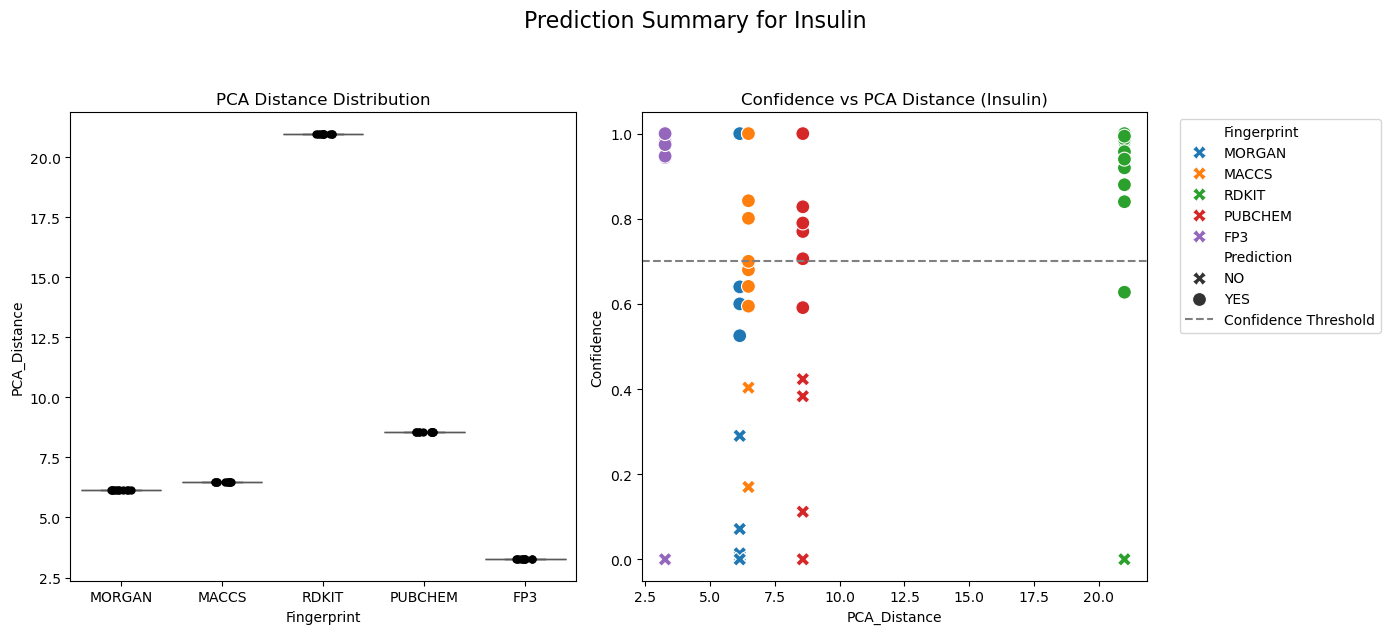

In [46]:
analyze_results(df_results=df, drug_name=drug, outpath=outpath)

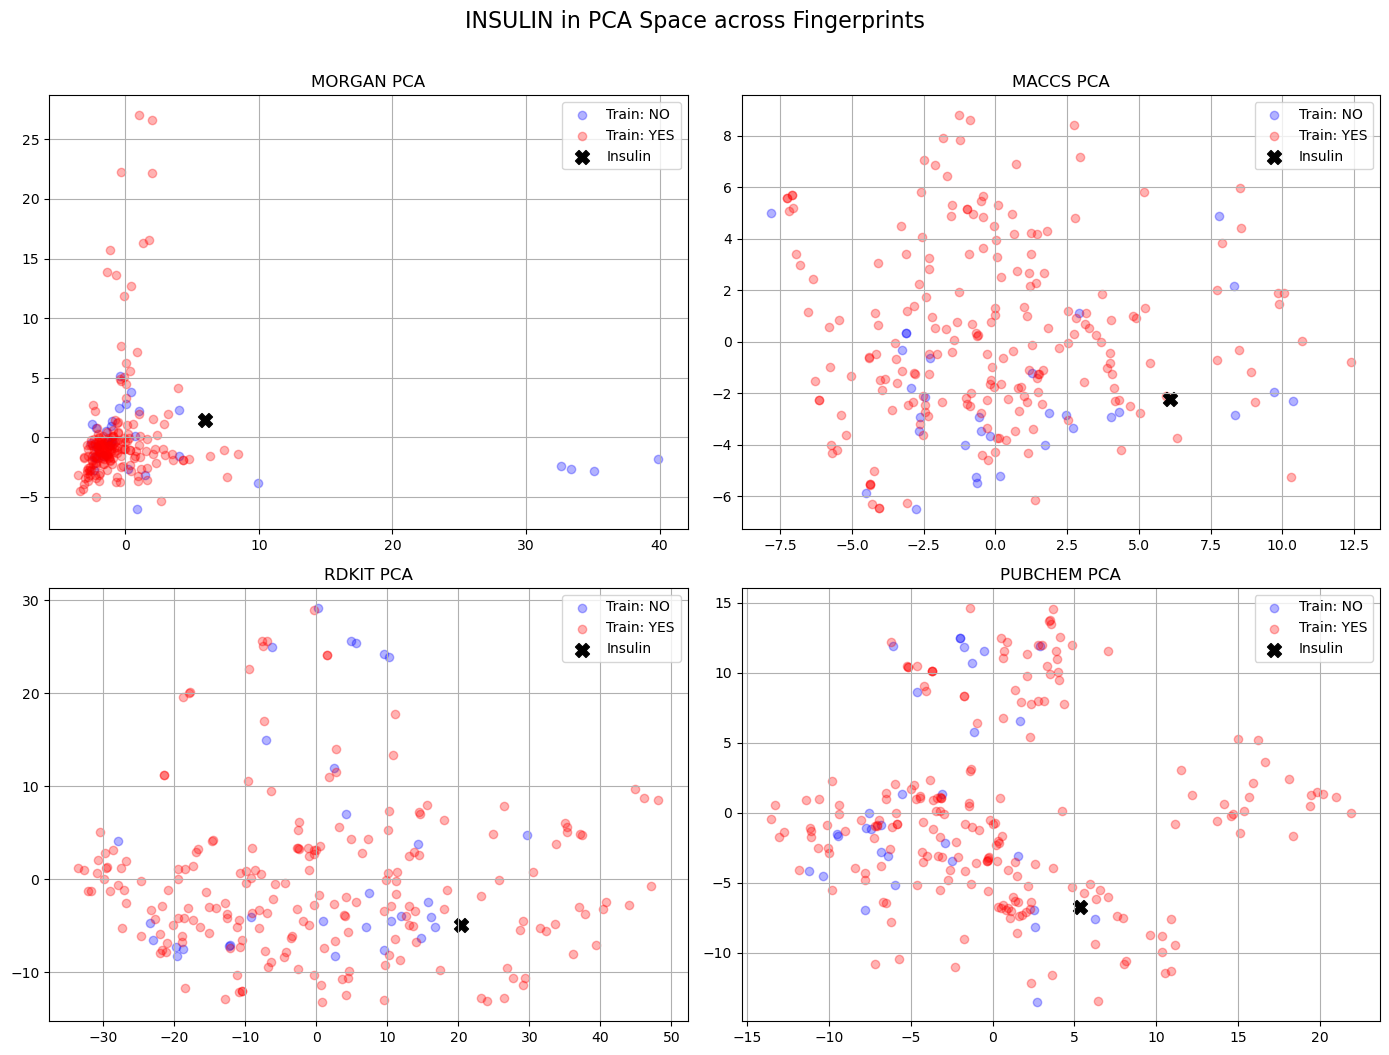

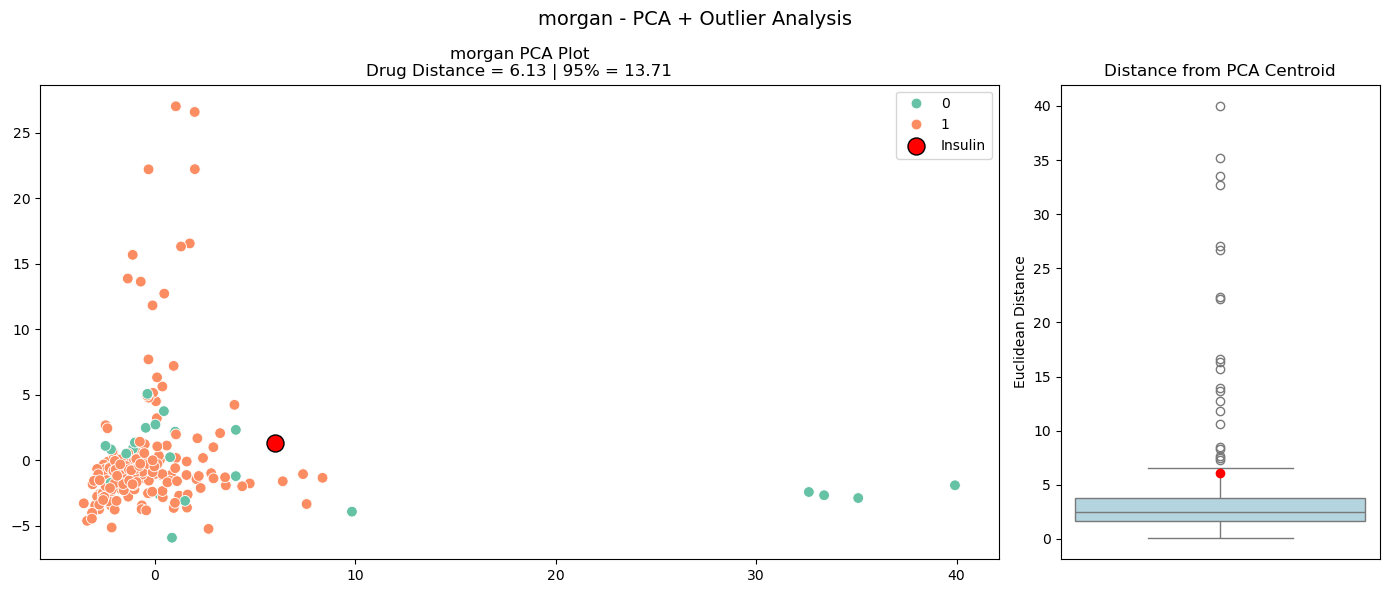

{'distance': 6.128952203003709,
 'is_outlier': False,
 'percentiles': {'min': 0.11734863759489282,
  '25%': 1.699139543634104,
  '50%': 2.461330957267991,
  '75%': 3.7815429689029068,
  '95%': 13.708476651633363,
  'max': 39.969695411659906}}

In [48]:
plot_pca_fingerprints(drug_name=drug, target_labels=placenta_target_labels, outpath=outpath)
plot_pca_fingerprints_with_boxplot(drug_name=drug, fp="morgan",target_labels=placenta_target_labels, outpath=outpath)


# Based on the CONVNEXT MODEL

In [ ]:
#run inference on models with SMOTE

fp_path = './Placenta_Fingerprints/'

#Hypertension drug study
avalon_SVC_param = {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
standard_KNN_param = {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
avalon_MLP_param = {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 200, 50), 'learning_rate': 'adaptive', 'max_iter': 600, 'solver': 'adam'}
avalon_lgbm_param  ={'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.01, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 12, 'objective': 'binary', 'reg_alpha': 2, 'reg_lambda': 10, 'seed': 500, 'subsample': 0.7}
fp3_rf_param  = {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}

#load data for FP and ground truth
X = np.load(fp_path+'fp3.npy', allow_pickle=True)
y = np.load('./placenta_target.npy',allow_pickle=True)

#pre-processing and normalization
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

#Dimensionality Reduction
pca = PCA(n_components = 0.95)
X = pca.fit_transform(X)

#Load, Scale, and transform hypertensive drugs
X_infer = np.load('./Nix_TAM_inference/.npy', allow_pickle=True)
X_infer = scaler.transform(X_infer)
X_infer = pca.transform(X_infer)

# #Gridsearch
imba_pipeline = Pipeline(steps=[('oversample',SMOTE(random_state=7)),
                          ('model', RandomForestClassifier(**fp3_rf_param))]) #LGBMClassifier, RandomForestClassifier, KNeighborsClassifier, ExtraTreesClassifier


imba_pipeline.fit(X,y)
print("Model Trained")

In [186]:
#run inference on models with SMOTE

fp_path = './Placenta_Fingerprints/'

#Hypertension drug study
avalon_SVC_param = {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
standard_KNN_param = {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
avalon_MLP_param = {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 200, 50), 'learning_rate': 'adaptive', 'max_iter': 600, 'solver': 'adam'}
avalon_lgbm_param  ={'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'is_unbalance': True, 'learning_rate': 0.01, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 12, 'objective': 'binary', 'reg_alpha': 2, 'reg_lambda': 10, 'seed': 500, 'subsample': 0.7}
fp3_rf_param  = {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 50}

#load data for FP and ground truth
X = np.load(fp_path+'fp3.npy', allow_pickle=True)
y = np.load('./placenta_target.npy',allow_pickle=True)

#pre-processing and normalization
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

#Dimensionality Reduction
pca = PCA(n_components = 0.95)
X = pca.fit_transform(X)

#Load, Scale, and transform hypertensive drugs
X_infer = np.load('./inference_drugs_placenta/placenta_diabetes_fp3.npy', allow_pickle=True)
X_infer = scaler.transform(X_infer)
X_infer = pca.transform(X_infer)

# #Gridsearch
imba_pipeline = Pipeline(steps=[('oversample',SMOTE(random_state=7)),
                          ('model', RandomForestClassifier(**fp3_rf_param))]) #LGBMClassifier, RandomForestClassifier, KNeighborsClassifier, ExtraTreesClassifier


imba_pipeline.fit(X,y)
print("Model Trained")

NameError: name 'PCA' is not defined

In [ ]:
# 1. Define your molecule
smiles = 'CCOc1ccccc1OCCN[C@@H](C)Cc1ccc(OC)c(c1)S(=O)(=O)N'
mol    = Chem.MolFromSmiles(smiles)

# 2. Generate a 2048‐bit Morgan fingerprint (radius=2)
fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
fp    = fpgen.GetFingerprint(mol)

# 3. Convert to numpy array of shape (1, 2048)
bitstr = fp.ToBitString()                         # e.g. "0101001…"
arr    = np.array(list(map(int, bitstr)), dtype=np.int8)
arr    = arr.reshape(1, -1)                       # now shape is (1, 2048)

# 4. Save it where the PlacentaBarrier code will find it
out_dir = './Extracted_Fingerprints'
os.makedirs(out_dir, exist_ok=True)
outfile = os.path.join(out_dir, 'morgan_tamsulosin.npy')
np.save(outfile, arr)

print(f"Saved fingerprint shape {arr.shape} to {outfile}")

In [2]:
from rdkit.Chem import MACCSkeys

fp_maccs = MACCSkeys.GenMACCSKeys(mol)              # 166‐bit fingerprint
arr2      = np.array(list(map(int, fp_maccs.ToBitString())), dtype=int).reshape(1, -1)
np.save('./Extracted_Fingerprints/maccs_tamsulosin.npy', arr2)


In [3]:
from rdkit.Chem import RDKFingerprint

fp_rdk = Chem.RDKFingerprint(mol)                   # defaults to 2048 bits
arr3   = np.array(list(map(int, fp_rdk.ToBitString())), dtype=int).reshape(1, -1)
np.save('./Extracted_Fingerprints/rdkit_tamsulosin.npy', arr3)


# Verify before inference

In [4]:
for fname in os.listdir('./Extracted_Fingerprints'):
    data = np.load(f'./Extracted_Fingerprints/{fname}', allow_pickle=True)
    print(fname, data.shape)

klekota-roth.npy (2304, 4860)
graph.npy (2304, 1024)
substructure.npy (2304, 1024)
maccs_tamsulosin.npy (1, 167)
rdkit.npy (2304, 2048)
maccs.npy (2304, 166)
rdkit_tamsulosin.npy (1, 2048)
morgan.npy (2304, 1024)
avalon.npy (2304, 512)
estate.npy (2304, 79)
atom-pair.npy (2304,)
rdk-maccs.npy (2304, 167)
pubchem.npy (2304, 881)
topological-torsion.npy (2304,)
extended.npy (2304, 1024)
signature.npy (2304,)
morgan_tamsulosin.npy (1, 2048)
lingo.npy (2304,)
standard.npy (2304, 1024)
fp3.npy (2304, 1024)
fp2.npy (2304, 1024)
1D_2D_imputed_KNN.npy (2304, 1441)
fp4.npy (2304, 1024)
hybridization.npy (2304, 1024)
mol2vec.npy (2304, 300)


In [2]:
#importing modules
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import KernelPCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def se_block(in_block, ch, ratio=16):
    x = GlobalAveragePooling1D()(in_block)
    x = Dense(ch//ratio, activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)
    return Multiply()([in_block, x])

def convnext_block(x, filters, kernel_size= 3):
    
    y = Conv1D(kernel_size=kernel_size,
               dilation_rate=3,
               filters=filters,
               padding="same")(x)
    
    y = LayerNormalization(axis=-1, center=True, scale=True)(y)
    
    y = Conv1D(kernel_size=1,
               filters=filters*4,
               padding="same")(y)

    
    y = Activation('gelu')(y)
    
    y = Conv1D(kernel_size=1,
               filters=filters,
               padding="same")(y)
    
    #ADD SE 
    
    y = se_block(y, K.int_shape(y)[2], ratio=4)
    
    
    #expand skipconnection to accomodate for increasing channels
    if K.int_shape(x)!=K.int_shape(y):
        x = Conv1D(kernel_size=1,
               filters=filters,
               padding="same")(x)
    
    out = Add()([x, y])
    
    return out

def create_model(num_features):
    num_features = num_features
    #CNN network

    inputs = Input(shape=(num_features,1))

    conv1 = convnext_block(inputs, filters=16, kernel_size= 3)
    conv1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = convnext_block(conv1, filters=32, kernel_size= 3)
    conv2 = MaxPooling1D(pool_size=2)(conv2)
    
    conv3 = convnext_block(conv2, filters=64, kernel_size= 3)
    conv3 = convnext_block(conv3, filters=64, kernel_size= 3)
    conv3 = convnext_block(conv3, filters=64, kernel_size= 3)
    conv3 = MaxPooling1D(pool_size=2)(conv3)
    
    conv4 = convnext_block(conv3, filters=128, kernel_size= 3)
    conv4 = MaxPooling1D(pool_size=2)(conv4)
    
    flat = Flatten()(conv4)
    
    #lstm1 = LSTM(32, return_sequences=True)(conv4)
    #att_output = Attention(units=100)(conv4) #Attention(context='many-to-one', alignment_type=attention_type, model_api='functional')(conv4)
    
    D = Dense(1, activation='sigmoid')(flat)
    
    return tf.keras.Model(inputs, D)
